# **Load ChEMBL data**

In [12]:
! python --version

Python 3.7.6


In [9]:
# Install ChEMBL web service package
! pip install chembl_webresource_client

     |████████████████████████████████| 51 kB 232 kB/s 
  Using cached requests_cache-0.6.0-py2.py3-none-any.whl (40 kB)
  Using cached url_normalize-1.4.3-py2.py3-none-any.whl (6.8 kB)
  Created wheel for chembl-webresource-client: filename=chembl_webresource_client-0.10.2-py3-none-any.whl size=55661 sha256=6b1ed114eef4baad66726200a5756f816590e20ef28938049d4756645200a908
  Stored in directory: /root/.cache/pip/wheels/6b/b6/01/3ac263f66b426db41f56f1f93e9afab34deea55cefa34b3253
  Created wheel for easydict: filename=easydict-1.9-py3-none-any.whl size=6349 sha256=0881d912290152deba4d358a8844c3c2413199d1020173acab03a181e81f9d0d
  Stored in directory: /root/.cache/pip/wheels/88/96/68/c2be18e7406804be2e593e1c37845f2dd20ac2ce1381ce40b0
Successfully built chembl-webresource-client easydict


In [11]:
from chembl_webresource_client.new_client import new_client

TypeError: ignored

In [ ]:
# Import necessary libraries
import pandas as pd
from chembl_webresource_client.new_client import new_client

In [ ]:
# Target search in ChEMBL database
target = new_client.target
target_query = target.search('VEGFR')
targets = pd.DataFrame.from_dict(target_query)
targets.head()

,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,[],Danio rerio,Vascular endothelial growth factor receptor 2,11.0,False,CHEMBL2331049,"[{'accession': 'Q5GIT4', 'component_descriptio...",SINGLE PROTEIN,7955
1,"[{'xref_id': 'FLT4', 'xref_name': None, 'xref_...",Homo sapiens,Vascular endothelial growth factor receptor 3,10.0,False,CHEMBL1955,"[{'accession': 'P35916', 'component_descriptio...",SINGLE PROTEIN,9606
2,"[{'xref_id': 'P35917', 'xref_name': None, 'xre...",Mus musculus,Vascular endothelial growth factor receptor 3,10.0,False,CHEMBL4758,"[{'accession': 'P35917', 'component_descriptio...",SINGLE PROTEIN,10090
3,[],Homo sapiens,Vascular endothelial growth factor receptor,10.0,False,CHEMBL2095227,"[{'accession': 'P17948', 'component_descriptio...",PROTEIN FAMILY,9606
4,[],Homo sapiens,Vascular endothelial growth factor receptor 2 ...,10.0,False,CHEMBL2111409,"[{'accession': 'P35916', 'component_descriptio...",SELECTIVITY GROUP,9606


In [ ]:
# The first entry is what we need
selected_target = targets.target_chembl_id[1]
selected_target

'CHEMBL1955'

In [ ]:
# Retrieve bioactivity data
activity = new_client.activity
res = activity.filter(target_chembl_id=selected_target) 

In [ ]:
df = pd.DataFrame.from_dict(res)
print(df.shape)
df.head(3)

(3009, 45)


,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,bao_label,canonical_smiles,data_validity_comment,data_validity_description,document_chembl_id,document_journal,document_year,ligand_efficiency,molecule_chembl_id,molecule_pref_name,parent_molecule_chembl_id,pchembl_value,potential_duplicate,qudt_units,record_id,relation,src_id,standard_flag,standard_relation,standard_text_value,standard_type,standard_units,standard_upper_value,standard_value,target_chembl_id,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,34278,[],CHEMBL820215,Selectivity for Vascular endothelial growth fa...,B,None,None,BAO_0000179,BAO_0000357,single protein format,Cc1ccc(Nc2ncc(-c3ccccc3)s2)nc1,None,None,CHEMBL1146769,Bioorg. Med. Chem. Lett.,2004.0,None,CHEMBL330621,None,CHEMBL330621,None,False,None,185989,=,1,False,=,None,Selectivity,None,None,1.0,CHEMBL1955,Homo sapiens,Vascular endothelial growth factor receptor 3,9606,None,None,Selectivity,None,None,None,1.0
1,None,37864,[],CHEMBL820215,Selectivity for Vascular endothelial growth fa...,B,None,None,BAO_0000179,BAO_0000357,single protein format,Cc1ccnc(Nc2ncc(-c3ccccc3)s2)c1,None,None,CHEMBL1146769,Bioorg. Med. Chem. Lett.,2004.0,None,CHEMBL319065,None,CHEMBL319065,None,False,None,185988,=,1,False,=,None,Selectivity,None,None,2.0,CHEMBL1955,Homo sapiens,Vascular endothelial growth factor receptor 3,9606,None,None,Selectivity,None,None,None,2.0
2,None,40259,[],CHEMBL820215,Selectivity for Vascular endothelial growth fa...,B,None,None,BAO_0000179,BAO_0000357,single protein format,Cc1cccc(Nc2ncc(-c3ccccc3)s2)n1,None,None,CHEMBL1146769,Bioorg. Med. Chem. Lett.,2004.0,None,CHEMBL98385,None,CHEMBL98385,None,False,None,185990,=,1,False,=,None,Selectivity,None,None,3.0,CHEMBL1955,Homo sapiens,Vascular endothelial growth factor receptor 3,9606,None,None,Selectivity,None,None,None,3.0


In [ ]:
file_name = selected_target+'_raw_data.csv'
df.to_csv(file_name, index=False)

# **Data Filtering**

In [ ]:
df2 = pd.read_csv(file_name)
df2.shape

(3009, 45)

## **Target Organism = 'Homo Sapiens'**

In [ ]:
# Check if the data only has target_organism=='Homo sapiens'
print(pd.unique(df2['target_organism']))

# Filter data by target_organism=='Homo sapiens'
df2=df2[df2['target_organism'].isin(['Homo sapiens'])]
print(pd.unique(df2['target_organism']))
df2.shape

['Homo sapiens']
['Homo sapiens']


(3009, 45)

## **Standard Type = 'IC50'**

In [ ]:
# Check if the data only has standard_type=='IC50'
print(pd.unique(df2['standard_type']))

# Filter data by standard_type=='IC50'
df2=df2[df2['standard_type'].isin(['IC50'])]
print(pd.unique(df2['standard_type']))
df2.shape

['Selectivity' 'IC50' 'Inhibition' 'NI' 'Kd' 'Ki' 'Activity'
 'Residual activity' 'EC50' 'Residual Activity' 'INH' 'GI50' '% Control'
 '% residual kinase activity' '% Ctrl'
 '% Residual activity with Skepinone-L']
['IC50']


(553, 45)

##**Standard Unit = ['nM', 'uM', 'pM']**

In [ ]:
print(pd.unique(df2['standard_units']))
# Filter data by units = ['nM','uM','pM']
units = ['nM','uM','pM']
df2=df2[df2['standard_units'].isin(units)].reset_index().drop(columns='index')

print(pd.unique(df2['standard_units']))
df2.shape

['nM' nan 'ug.mL-1']
['nM']


(525, 45)

In [ ]:
file_name = selected_target+'_filtered_data.csv'
df2.to_csv(file_name, index=False)

# **Data Cleaning**


In [ ]:
df3 = pd.read_csv(file_name)
df3.shape

(525, 45)

## **Drop Missing values**

* Drop missing SMILE notation
* Drop missing standard values


In [ ]:
# Drop compounds with missing standard_value.
df3 = df3[df3['standard_value'].notna()]
print(df3.shape)

# Drop compounds with missing canonical_smiles column.
df3 = df3[df3['canonical_smiles'].notna()]
print(df3.shape)

# Reset index
df3 = df3.reset_index().drop(columns='index')
print(df3.shape)
df3.head(3)

(525, 45)
(525, 45)
(525, 45)


,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,bao_label,canonical_smiles,data_validity_comment,data_validity_description,document_chembl_id,document_journal,document_year,ligand_efficiency,molecule_chembl_id,molecule_pref_name,parent_molecule_chembl_id,pchembl_value,potential_duplicate,qudt_units,record_id,relation,src_id,standard_flag,standard_relation,standard_text_value,standard_type,standard_units,standard_upper_value,standard_value,target_chembl_id,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,NaN,506177,[],CHEMBL821012,Inhibition of Vascular endothelial growth fact...,B,NaN,NaN,BAO_0000190,BAO_0000357,single protein format,CC(C)(C)c1nc2c3ccc(F)cc3c3c(=O)[nH]ccc3c2[nH]1,NaN,NaN,CHEMBL1135866,Bioorg. Med. Chem. Lett.,2002.0,"{'bei': '19.92', 'le': '0.37', 'lle': '2.17', ...",CHEMBL21156,NaN,CHEMBL21156,6.16,False,http://www.openphacts.org/units/Nanomolar,25954,=,1,True,=,NaN,IC50,nM,NaN,690.0,CHEMBL1955,Homo sapiens,Vascular endothelial growth factor receptor 3,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,0.69
1,NaN,686001,[],CHEMBL820849,Inhibition of Vascular endothelial growth fact...,B,NaN,NaN,BAO_0000190,BAO_0000357,single protein format,CC(O)C(/N=C1/C=C(O)/C(=N\C(C(=O)O)C(C)O)C=C1O)...,NaN,NaN,CHEMBL1145828,J. Med. Chem.,2003.0,"{'bei': '16.13', 'le': '0.31', 'lle': '6.09', ...",CHEMBL327725,NaN,CHEMBL327725,5.52,False,http://www.openphacts.org/units/Nanomolar,184695,=,1,True,=,NaN,IC50,nM,NaN,3000.0,CHEMBL1955,Homo sapiens,Vascular endothelial growth factor receptor 3,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,3.00
2,NaN,750660,[],CHEMBL820850,Inhibition of Vascular endothelial growth fact...,B,NaN,NaN,BAO_0000190,BAO_0000357,single protein format,O=C(Cc1ccc2ccccc2c1)Nc1cc(C2CC2)n[nH]1,NaN,NaN,CHEMBL1148336,J. Med. Chem.,2004.0,NaN,CHEMBL115220,NaN,CHEMBL115220,NaN,False,http://www.openphacts.org/units/Nanomolar,215208,>,1,True,>,NaN,IC50,nM,NaN,10000.0,CHEMBL1955,Homo sapiens,Vascular endothelial growth factor receptor 3,9606,NaN,NaN,IC50,nM,UO_0000065,NaN,10000.00


## **Convert Standard Units (nM)**

In [ ]:
#units = ['nM','uM','pM']

standard_unit_nM = []

for i,j in zip(df3['standard_units'],df3['standard_value']):
    if i == 'nM':
      standard_unit_nM.append(float(j))
    elif i == 'uM':
      standard_unit_nM.append(float(1000*float(j)))
    elif i == 'pM':
      standard_unit_nM.append(float(float(j)/1000))

In [ ]:
#standard_unit_nM
standard_value_nM = pd.Series(standard_unit_nM, name='standard_value_nM')
print(standard_value_nM.shape)

(525,)


In [ ]:
print(df3.shape)

df3 = pd.concat([df3, standard_value_nM], axis=1)
print(df3.shape)

# Sort data by ascending 'standard_unit_nM' values.
df3 = df3.sort_values('standard_value_nM',ascending=True).reset_index().drop(columns='index')
df3.head(3)
#df3[['standard_value','standard_units','standard_value_nM']].loc[(df3['standard_units']=='uM')].tail(5)

(525, 45)
(525, 46)


,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,bao_label,canonical_smiles,data_validity_comment,data_validity_description,document_chembl_id,document_journal,document_year,ligand_efficiency,molecule_chembl_id,molecule_pref_name,parent_molecule_chembl_id,pchembl_value,potential_duplicate,qudt_units,record_id,relation,src_id,standard_flag,standard_relation,standard_text_value,standard_type,standard_units,standard_upper_value,standard_value,target_chembl_id,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value,standard_value_nM
0,NaN,18854179,[],CHEMBL4307052,Inhibition of VEGFR3 (unknown origin),B,NaN,NaN,BAO_0000190,BAO_0000357,single protein format,CNC(=O)c1ccccc1Sc1ccc2c(/C=C/c3ccccn3)n[nH]c2c1,NaN,NaN,CHEMBL4304778,Eur J Med Chem,2019.0,"{'bei': '25.87', 'le': '0.49', 'lle': '5.36', ...",CHEMBL1289926,AXITINIB,CHEMBL1289926,10.0,False,http://www.openphacts.org/units/Nanomolar,3147182,=,1,True,=,NaN,IC50,nM,NaN,0.1,CHEMBL1955,Homo sapiens,Vascular endothelial growth factor receptor 3,9606,NaN,NaN,IC50,nM,UO_0000065,0.3,0.1,0.1
1,NaN,18784844,[],CHEMBL4271315,Inhibition of VEGFR3 (unknown origin),B,NaN,NaN,BAO_0000190,BAO_0000357,single protein format,CNC(=O)c1ccccc1Sc1ccc2c(/C=C/c3ccccn3)n[nH]c2c1,NaN,NaN,CHEMBL4270503,Eur J Med Chem,2017.0,"{'bei': '25.87', 'le': '0.49', 'lle': '5.36', ...",CHEMBL1289926,AXITINIB,CHEMBL1289926,10.0,True,http://www.openphacts.org/units/Nanomolar,3121531,=,1,True,=,NaN,IC50,nM,NaN,0.1,CHEMBL1955,Homo sapiens,Vascular endothelial growth factor receptor 3,9606,NaN,NaN,IC50,nM,UO_0000065,0.3,0.1,0.1
2,NaN,16815391,[],CHEMBL3871603,Inhibition of VEGFR3 (unknown origin),B,NaN,NaN,BAO_0000190,BAO_0000357,single protein format,CNC(=O)c1ccccc1Sc1ccc2c(CCc3ccccn3)n[nH]c2c1,NaN,NaN,CHEMBL3871274,Eur J Med Chem,2016.0,"{'bei': '25.74', 'le': '0.49', 'lle': '5.75', ...",CHEMBL3939307,NaN,CHEMBL3939307,10.0,False,http://www.openphacts.org/units/Nanomolar,2811953,=,1,True,=,NaN,IC50,nM,NaN,0.1,CHEMBL1955,Homo sapiens,Vascular endothelial growth factor receptor 3,9606,NaN,NaN,IC50,nM,UO_0000065,0.3,0.1,0.1


## **Duplicated Compounds**

In [ ]:
# Keep the one with minimum standard_value for duplicated ['compound_ID','target_ID']
df3 = df3.drop_duplicates(subset=['molecule_chembl_id','target_chembl_id'], keep='first').reset_index().drop(columns='index')
print(df3.shape)
df3.head(3)['standard_value_nM']

(452, 46)


0    0.1
1    0.1
2    0.2
Name: standard_value_nM, dtype: float64

##**Keep only useful columns**
#### **molecule_chembl_id, target_chembl_id, canonical_smiles, standard_value_nM**

In [ ]:
# Combine columns ('molecule_chembl_id','target_chembl_id','canonical_smiles','standard_value_nM') and bioactivity_class into a DataFrame
selection = ['molecule_chembl_id','target_chembl_id','canonical_smiles','standard_value_nM']
df3 = df3[selection] #.rename(columns={'Molecule ChEMBL ID':'molecule_chembl_id','Smiles':'canonical_smiles','standard_unit_nM':'standard_value'})
print(df3.shape)
df3

(452, 4)


,molecule_chembl_id,target_chembl_id,canonical_smiles,standard_value_nM
0,CHEMBL1289926,CHEMBL1955,CNC(=O)c1ccccc1Sc1ccc2c(/C=C/c3ccccn3)n[nH]c2c1,0.10
1,CHEMBL3939307,CHEMBL1955,CNC(=O)c1ccccc1Sc1ccc2c(CCc3ccccn3)n[nH]c2c1,0.10
2,CHEMBL1940109,CHEMBL1955,COCCOc1cc2ncnc(Oc3cnn(CC(=O)Nc4cccc(OC)c4)c3)c...,0.20
3,CHEMBL1289494,CHEMBL1955,COc1cc2nccc(Oc3ccc(NC(=O)Nc4cc(C)on4)c(Cl)c3)c...,0.24
4,CHEMBL1940108,CHEMBL1955,COc1cccc(NC(=O)Cn2cc(Oc3ncnc4cc(OC)c(OC)cc34)c...,0.40
...,...,...,...,...
447,CHEMBL1668417,CHEMBL1955,COc1cc(O)c2c(c1)/C=C\CCCC(=O)C[C@H](Br)C[C@H](...,65000.00
448,CHEMBL3689078,CHEMBL1955,NC(=O)Cc1ccccc1CCc1nc(Nc2ccc(C3CCNCC3)cc2OC(F)...,66000.00
449,CHEMBL1668416,CHEMBL1955,COc1cc(O)c2c(c1)/C=C\CCCC(=O)C[C@H](Cl)C[C@H](...,100000.00
450,CHEMBL4446681,CHEMBL1955,CN(CCc1ccc(-c2ccccc2)cc1)Cc1cn(C)c2ccc(C(=O)Nc...,100000.00


In [ ]:
file_name = selected_target+'_cleaned_data.csv'
df3.to_csv(file_name, index=False)

# **Labeling** 

In [ ]:
import pandas as pd
df4 = pd.read_csv(file_name)
df4.shape

(452, 4)

## **Normalization (pIC50)**


In [ ]:
import numpy as np

def pIC50(input):
    pIC50 = []

    for i in input['standard_value_norm']:
        molar = i*(10**-9) # Converts nM to M
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop('standard_value_norm', 1)
        
    return x

In [ ]:
def norm_value(input):
    norm = []

    for i in input['standard_value_nM']:
        #  Values greater than 100,000,000 will be fixed at 100,000,000 otherwise the negative logarithmic value will become negative.
        if i > 100000000:
          i = 100000000
        norm.append(i)

    input['standard_value_norm'] = norm
    x = input.drop('standard_value_nM', 1)
        
    return x

In [ ]:
# Normalization
df5 = norm_value(df4)
df_norm = pIC50(df5)
df_norm.head(3) #.pIC50.describe()

,molecule_chembl_id,target_chembl_id,canonical_smiles,pIC50
0,CHEMBL1289926,CHEMBL1955,CNC(=O)c1ccccc1Sc1ccc2c(/C=C/c3ccccn3)n[nH]c2c1,10.00000
1,CHEMBL3939307,CHEMBL1955,CNC(=O)c1ccccc1Sc1ccc2c(CCc3ccccn3)n[nH]c2c1,10.00000
2,CHEMBL1940109,CHEMBL1955,COCCOc1cc2ncnc(Oc3cnn(CC(=O)Nc4cccc(OC)c4)c3)c...,9.69897


In [ ]:
botton_line = np.percentile(df4['standard_value_nM'], 25)
top_line = np.percentile(df4['standard_value_nM'], 75)
print(' 20-th =',botton_line,'\n','80-th =',top_line)

 20-th = 12.95 
 80-th = 2557.5


In [ ]:
botton_line = np.percentile(df_norm.pIC50, 25)
top_line = np.percentile(df_norm.pIC50, 75)
print(' 20-th =',botton_line,'\n','80-th =',top_line)

 20-th = 5.592258627400678 
 80-th = 7.887739993357905


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


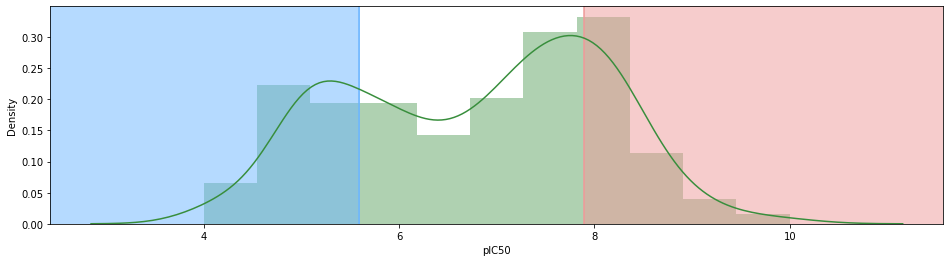

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 4))

#plotting the two lines
p1 = plt.axvline(x=botton_line,color='#6DB6FF')
p2 = plt.axvline(x=top_line,color='#EF9A9A')

#plotting the PDF
ax = sns.distplot(df_norm['pIC50'], hist=True, color='#388E3C')

xlim = ax.get_xlim()
ax.axvspan(xlim[0], botton_line, color='#6DB6FF', alpha=0.5)
ax.axvspan(top_line, xlim[1], color='#EF9A9A', alpha=0.5)
#reset xlim
ax.set_xlim(xlim)
plt.show()

## **Labeling**

In [ ]:
bioactivity_threshold = []
for i in df_norm.pIC50:
  if float(i) >= top_line:
    bioactivity_threshold.append(1)
  elif float(i) <= botton_line:
    bioactivity_threshold.append(0)
  else:
    bioactivity_threshold.append("intermediate")

In [ ]:
# Combine the data
bioactivity_class = pd.Series(bioactivity_threshold, name='bioactivity_class')
df6 = pd.concat([df_norm, bioactivity_class], axis=1)
print(df6.shape)
df6.head(5)

(452, 5)


,molecule_chembl_id,target_chembl_id,canonical_smiles,pIC50,bioactivity_class
0,CHEMBL1289926,CHEMBL1955,CNC(=O)c1ccccc1Sc1ccc2c(/C=C/c3ccccn3)n[nH]c2c1,10.000000,1
1,CHEMBL3939307,CHEMBL1955,CNC(=O)c1ccccc1Sc1ccc2c(CCc3ccccn3)n[nH]c2c1,10.000000,1
2,CHEMBL1940109,CHEMBL1955,COCCOc1cc2ncnc(Oc3cnn(CC(=O)Nc4cccc(OC)c4)c3)c...,9.698970,1
3,CHEMBL1289494,CHEMBL1955,COc1cc2nccc(Oc3ccc(NC(=O)Nc4cc(C)on4)c(Cl)c3)c...,9.619789,1
4,CHEMBL1940108,CHEMBL1955,COc1cccc(NC(=O)Cn2cc(Oc3ncnc4cc(OC)c(OC)cc34)c...,9.397940,1


In [ ]:
print(
    ' active',df6['bioactivity_class'][df6['bioactivity_class']==1].count(),'\n',
    'inactive',df6['bioactivity_class'][df6['bioactivity_class']==0].count(),'\n',
    'intermediate',df6['bioactivity_class'][df6['bioactivity_class']=="intermediate"].count()
)

 active 113 
 inactive 113 
 intermediate 226


In [ ]:
file_name = selected_target+'_3cls_labeled_data.csv'
df6.to_csv(file_name, index=False)

## **Removing 'intermediate' class**

In [ ]:
df_2class = df6[df6['bioactivity_class'] != 'intermediate']
print(df_2class.shape)
df_2class.head(3)

(226, 5)


,molecule_chembl_id,target_chembl_id,canonical_smiles,pIC50,bioactivity_class
0,CHEMBL1289926,CHEMBL1955,CNC(=O)c1ccccc1Sc1ccc2c(/C=C/c3ccccn3)n[nH]c2c1,10.00000,1
1,CHEMBL3939307,CHEMBL1955,CNC(=O)c1ccccc1Sc1ccc2c(CCc3ccccn3)n[nH]c2c1,10.00000,1
2,CHEMBL1940109,CHEMBL1955,COCCOc1cc2ncnc(Oc3cnn(CC(=O)Nc4cccc(OC)c4)c3)c...,9.69897,1


In [ ]:
bi_file_name = selected_target+'_binary_2cls_labeled_data.csv'
df_2class.to_csv(bi_file_name, index=False)

#**(Multi-Labeled) Data Transformation**

##**Load existing mlc-data**

In [ ]:
mlc_df = pd.read_csv('original_mlc_data.csv')

In [ ]:
existing_targets_ls=[]
existing_targets_ls = list(mlc_df.columns[2:])
existing_targets_ls

['CHEMBL203', 'CHEMBL1957', 'CHEMBL2842', 'CHEMBL614725']

In [ ]:
mlc_df[existing_targets_ls] = mlc_df[existing_targets_ls].astype('int')

print(mlc_df.shape)
mlc_df.head(2)

(5267, 6)


,molecule_chembl_id,canonical_smiles,CHEMBL203,CHEMBL1957,CHEMBL2842,CHEMBL614725
0,CHEMBL3645910,CCc1ncnc(-c2cc(F)c(C(=O)N3CCN4CCC[C@H]4C3)c(Cl...,0,0,1,0
1,CHEMBL558955,COC(=O)N1CCC(n2ncc3c(N4CCOCC4)nc(-c4ccc(NC(=O)...,0,0,1,0


In [ ]:
new_df = pd.read_csv(bi_file_name)
print(new_df.shape)
new_df.head(3)

(226, 5)


,molecule_chembl_id,target_chembl_id,canonical_smiles,pIC50,bioactivity_class
0,CHEMBL1289926,CHEMBL1955,CNC(=O)c1ccccc1Sc1ccc2c(/C=C/c3ccccn3)n[nH]c2c1,10.00000,1
1,CHEMBL3939307,CHEMBL1955,CNC(=O)c1ccccc1Sc1ccc2c(CCc3ccccn3)n[nH]c2c1,10.00000,1
2,CHEMBL1940109,CHEMBL1955,COCCOc1cc2ncnc(Oc3cnn(CC(=O)Nc4cccc(OC)c4)c3)c...,9.69897,1


In [ ]:
new_target = new_df.target_chembl_id[1]
existing_targets_ls.append(new_target)

selection = ['molecule_chembl_id','canonical_smiles','bioactivity_class']
new_df = new_df[selection].rename({'bioactivity_class': new_target}, axis='columns')
new_df.head(3)

,molecule_chembl_id,canonical_smiles,CHEMBL1955
0,CHEMBL1289926,CNC(=O)c1ccccc1Sc1ccc2c(/C=C/c3ccccn3)n[nH]c2c1,1
1,CHEMBL3939307,CNC(=O)c1ccccc1Sc1ccc2c(CCc3ccccn3)n[nH]c2c1,1
2,CHEMBL1940109,COCCOc1cc2ncnc(Oc3cnn(CC(=O)Nc4cccc(OC)c4)c3)c...,1


In [ ]:
multi_concat = pd.concat([mlc_df, new_df])

multi_dup_df = multi_concat[multi_concat.duplicated(['molecule_chembl_id'])]
multi_dup_df.tail(3)

,molecule_chembl_id,canonical_smiles,CHEMBL203,CHEMBL1957,CHEMBL2842,CHEMBL614725,CHEMBL1955
213,CHEMBL1957190,CC(C)n1c2c(c3c1-c1ccccc1C3=O)C(=O)CCC2,NaN,NaN,NaN,NaN,0.0
217,CHEMBL383264,N[C@H](COc1cncc(-c2ccc3cnccc3c2)c1)Cc1c[nH]c2c...,NaN,NaN,NaN,NaN,0.0
224,CHEMBL4446681,CN(CCc1ccc(-c2ccccc2)cc1)Cc1cn(C)c2ccc(C(=O)Nc...,NaN,NaN,NaN,NaN,0.0


##**Data Aggregation**

In [ ]:
#multi_res = multi_concat.groupby(['molecule_chembl_id','canonical_smiles']).agg({'CHEMBL614725' : 'max',new_target : 'max'})
multi_res = multi_concat.groupby(['molecule_chembl_id','canonical_smiles']).agg({'CHEMBL203' : 'max', 'CHEMBL1957' : 'max', 'CHEMBL2842' : 'max', 'CHEMBL614725' : 'max', new_target : 'max'})

In [ ]:
multi_res = multi_res.fillna(0).astype('int')

multi_res.insert(loc=0, column='canonical_smiles', value=multi_res.index.get_level_values('canonical_smiles'))
multi_res.insert(loc=0, column='molecule_chembl_id', value=multi_res.index.get_level_values('molecule_chembl_id'))

multi_res = multi_res.reset_index(drop=True)

multi_res

,molecule_chembl_id,canonical_smiles,CHEMBL203,CHEMBL1957,CHEMBL2842,CHEMBL614725,CHEMBL1955
0,CHEMBL10,C[S+]([O-])c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc...,0,0,0,0,0
1,CHEMBL101299,N[C@H]1CCN(c2c(F)cc3c(=O)c(C(=O)O)cn4c5ccccc5o...,0,0,0,1,0
2,CHEMBL101871,C[C@]1([C@H]2Cc3ccc4oc5c(N6CC[C@H](N)C6)c(F)cc...,0,0,0,1,0
3,CHEMBL103667,Cc1ccc(-n2nc(C(C)(C)C)cc2NC(=O)Nc2ccc(OCCN3CCO...,0,0,0,0,0
4,CHEMBL104468,O=c1cc(N2CCOCC2)oc2c1ccc1ccccc12,0,0,0,0,0
...,...,...,...,...,...,...,...
5452,CHEMBL9514,COC(=O)Nc1nc2ccc(C(=O)c3cccs3)cc2[nH]1,0,0,0,1,0
5453,CHEMBL96926,C/C=C(/C)C(=O)O[C@H]1C(C)=C2[C@@H]3OC(=O)[C@@]...,0,0,0,1,0
5454,CHEMBL98,O=C(CCCCCCC(=O)Nc1ccccc1)NO,0,0,0,1,0
5455,CHEMBL98137,COc1ccc(Nc2ccnc3cc(OC)c(OC)cc23)cc1OC,0,0,0,0,0


In [ ]:
#check
#multi_res[multi_res['molecule_chembl_id']=='CHEMBL1289926']

In [ ]:
multi_res[multi_res.duplicated(['molecule_chembl_id'])].count()['molecule_chembl_id']

0

In [ ]:
mul_file_name = selected_target+'_multi_2cls_labeled_data.csv'
multi_res.to_csv(mul_file_name, index=False)

##**Update original_mlc_data.csv**

In [ ]:
multi_res.to_csv('original_mlc_data.csv')

# **Calculate PubChem fingerprint**

In [ ]:
df_mul = pd.read_csv(mul_file_name)
print(df_mul.shape)
df_mul.tail(3)

(5457, 7)


,molecule_chembl_id,canonical_smiles,CHEMBL203,CHEMBL1957,CHEMBL2842,CHEMBL614725,CHEMBL1955
5454,CHEMBL98,O=C(CCCCCCC(=O)Nc1ccccc1)NO,0,0,0,1,0
5455,CHEMBL98137,COc1ccc(Nc2ccnc3cc(OC)c(OC)cc23)cc1OC,0,0,0,0,0
5456,CHEMBL98350,O=c1cc(N2CCOCC2)oc2c(-c3ccccc3)cccc12,0,0,0,0,0


In [ ]:
df_bi = pd.read_csv(bi_file_name)
print(df_bi.shape)
df_bi.tail(3)

(226, 5)


,molecule_chembl_id,target_chembl_id,canonical_smiles,pIC50,bioactivity_class
223,CHEMBL1668416,CHEMBL1955,COc1cc(O)c2c(c1)/C=C\CCCC(=O)C[C@H](Cl)C[C@H](...,4.0,0
224,CHEMBL4446681,CHEMBL1955,CN(CCc1ccc(-c2ccccc2)cc1)Cc1cn(C)c2ccc(C(=O)Nc...,4.0,0
225,CHEMBL1668412,CHEMBL1955,COc1cc(O)c2c(c1)/C=C/CCCC(=O)C[C@H](Cl)C[C@H](...,4.0,0


## **Download PaDEL-Descriptor**

In [ ]:
! wget http://www.yapcwsoft.com/dd/padeldescriptor/PaDEL-Descriptor.zip

--2021-04-06 16:01:01--  http://www.yapcwsoft.com/dd/padeldescriptor/PaDEL-Descriptor.zip
Resolving www.yapcwsoft.com (www.yapcwsoft.com)... 118.189.195.172
Connecting to www.yapcwsoft.com (www.yapcwsoft.com)|118.189.195.172|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20875190 (20M) [application/zip]
Saving to: ‘PaDEL-Descriptor.zip’

PaDEL-Descriptor.zi 100%[===================>]  19.91M  7.23MB/s    in 2.8s    

2021-04-06 16:01:04 (7.23 MB/s) - ‘PaDEL-Descriptor.zip’ saved [20875190/20875190]



In [ ]:
! unzip PaDEL-Descriptor.zip

Archive:  PaDEL-Descriptor.zip
  inflating: Descriptors.xls         
  inflating: descriptors.xml         
   creating: lib/
  inflating: lib/ambit2-base-2.4.7-SNAPSHOT.jar  
  inflating: lib/ambit2-core-2.4.7-SNAPSHOT.jar  
  inflating: lib/ambit2-smarts-2.4.7-SNAPSHOT.jar  
  inflating: lib/appframework-1.0.3.jar  
  inflating: lib/cdk-1.4.15.jar      
  inflating: lib/commons-cli-1.2.jar  
  inflating: lib/guava-17.0.jar      
  inflating: lib/jama.jar            
  inflating: lib/jgrapht-0.6.0.jar   
  inflating: lib/l2fprod-common-all.jar  
  inflating: lib/libPaDEL-Descriptor.jar  
  inflating: lib/libPaDEL-Jobs.jar   
  inflating: lib/libPaDEL.jar        
  inflating: lib/swing-worker-1.1.jar  
  inflating: lib/vecmath1.2-1.14.jar  
  inflating: lib/xom-1.1.jar         
   creating: license/
  inflating: license/lgpl-2.1.txt    
  inflating: license/lgpl.license    
  inflating: license/LICENSE.txt     
  inflating: license/README - CDK    
  inflating: PaDEL-Descriptor.jar    


In [ ]:
# Modify the descriptors.xml file for calculation
import lxml.etree

# input
doc = lxml.etree.parse('descriptors.xml')
# modification
for el in doc.xpath("//Descriptor[@name!='PubchemFingerprinter']"):
  el.attrib['value'] = 'false'
# output
# open('output_file.xml', 'w').write(lxml.etree.tostring(doc))
doc.write('pubchemfingerprinter.xml')

## **Calculate Pubchem Fingerprints**

###**Binary**

In [ ]:
selection = ['canonical_smiles','molecule_chembl_id']
df_bi_selection = df_bi[selection]
print(df_bi_selection.shape)
df_bi_selection.to_csv('molecule.smi', sep='\t', index=False, header=False)

(226, 2)


In [ ]:
! cat molecule.smi | head -5

CNC(=O)c1ccccc1Sc1ccc2c(/C=C/c3ccccn3)n[nH]c2c1	CHEMBL1289926
CNC(=O)c1ccccc1Sc1ccc2c(CCc3ccccn3)n[nH]c2c1	CHEMBL3939307
COCCOc1cc2ncnc(Oc3cnn(CC(=O)Nc4cccc(OC)c4)c3)c2cc1OC	CHEMBL1940109
COc1cc2nccc(Oc3ccc(NC(=O)Nc4cc(C)on4)c(Cl)c3)c2cc1OC	CHEMBL1289494
COc1cccc(NC(=O)Cn2cc(Oc3ncnc4cc(OC)c(OC)cc34)cn2)c1	CHEMBL1940108


In [ ]:
! cat molecule.smi | wc -l

226


In [ ]:
! java -Xms1G -Xmx1G -Djava.awt.headless=true -jar ./PaDEL-Descriptor.jar -removesalt -standardizenitro -fingerprints -descriptortypes ./pubchemfingerprinter.xml -dir ./ -file binary_descriptors_output.csv

Processing CHEMBL1289926 in molecule.smi (1/226). 
Processing CHEMBL3939307 in molecule.smi (2/226). 
Processing CHEMBL1940109 in molecule.smi (3/226). Average speed: 3.11 s/mol.
Processing CHEMBL1289494 in molecule.smi (4/226). Average speed: 1.67 s/mol.
Processing CHEMBL1940108 in molecule.smi (5/226). Average speed: 1.35 s/mol.
Processing CHEMBL1668411 in molecule.smi (6/226). Average speed: 1.10 s/mol.
Processing CHEMBL2012519 in molecule.smi (7/226). Average speed: 0.99 s/mol.
Processing CHEMBL388978 in molecule.smi (9/226). Average speed: 0.82 s/mol.
Processing CHEMBL1173411 in molecule.smi (8/226). Average speed: 0.83 s/mol.
Processing CHEMBL495727 in molecule.smi (10/226). Average speed: 0.75 s/mol.
Processing CHEMBL3891581 in molecule.smi (11/226). Average speed: 0.74 s/mol.
Processing CHEMBL4453304 in molecule.smi (12/226). Average speed: 0.72 s/mol.
Processing CHEMBL4303275 in molecule.smi (14/226). Average speed: 0.66 s/mol.
Processing CHEMBL2180604 in molecule.smi (13/226)

In [ ]:
! ls -l

total 24936
-rw-r--r-- 1 root root   413087 Apr  6 16:02 binary_descriptors_output.csv
-rw-r--r-- 1 root root    47237 Apr  6 16:01 CHEMBL1955_3cls_labeled_data.csv
-rw-r--r-- 1 root root    21861 Apr  6 16:01 CHEMBL1955_binary_2cls_labeled_data.csv
-rw-r--r-- 1 root root    39392 Apr  6 16:00 CHEMBL1955_cleaned_data.csv
-rw-r--r-- 1 root root   386224 Apr  6 16:00 CHEMBL1955_filtered_data.csv
-rw-r--r-- 1 root root   441483 Apr  6 16:01 CHEMBL1955_multi_2cls_labeled_data.csv
-rw-r--r-- 1 root root  1549907 Apr  6 16:00 CHEMBL1955_raw_data.csv
-rw-r--r-- 1 root root   957952 Jun 26  2014 Descriptors.xls
-rw-r--r-- 1 root root     4669 Jun 13  2014 descriptors.xml
drwxr-xr-x 2 root root     4096 Jul 21  2014 lib
drwxr-xr-x 2 root root     4096 May  8  2012 license
-rw-r--r-- 1 root root    15701 Apr  6 16:01 molecule.smi
-rw-r--r-- 1 root root   467659 Apr  6 16:01 original_mlc_data.csv
-rw-r--r-- 1 root root   268084 Jul 21  2014 PaDEL-Descriptor.jar
-rw-r--r-- 1 root root 20875190 Jul

In [ ]:
bi_df_fp = pd.read_csv('binary_descriptors_output.csv')
bi_df_fp = bi_df_fp.rename({'Name': 'molecule_chembl_id'}, axis='columns')
print(bi_df_fp.shape)
bi_df_fp.tail(3)

(226, 882)


,molecule_chembl_id,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,PubchemFP36,PubchemFP37,PubchemFP38,...,PubchemFP841,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
223,CHEMBL3689078,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
224,CHEMBL1668412,1,1,1,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
225,CHEMBL4446681,1,1,1,0,0,0,0,0,0,1,1,1,1,1,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
bi_df_all = pd.merge(df_bi,bi_df_fp, on="molecule_chembl_id")
print(bi_df_all.shape)
bi_df_all.tail(3)

(226, 886)


,molecule_chembl_id,target_chembl_id,canonical_smiles,pIC50,bioactivity_class,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,...,PubchemFP841,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
223,CHEMBL1668416,CHEMBL1955,COc1cc(O)c2c(c1)/C=C\CCCC(=O)C[C@H](Cl)C[C@H](...,4.0,0,1,1,1,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
224,CHEMBL4446681,CHEMBL1955,CN(CCc1ccc(-c2ccccc2)cc1)Cc1cn(C)c2ccc(C(=O)Nc...,4.0,0,1,1,1,0,0,0,0,0,0,1,1,1,1,1,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
225,CHEMBL1668412,CHEMBL1955,COc1cc(O)c2c(c1)/C=C/CCCC(=O)C[C@H](Cl)C[C@H](...,4.0,0,1,1,1,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
binary_fp_file_name = selected_target+'_binary_FP_all_data.csv'
bi_df_all.to_csv(binary_fp_file_name, index=False)

###**Multi_Labeled**

In [ ]:
selection = ['canonical_smiles','molecule_chembl_id']
df_mul_selection = df_mul[selection]
print(df_mul_selection.shape)
df_mul_selection.to_csv('molecule.smi', sep='\t', index=False, header=False)

(5457, 2)


In [ ]:
! cat molecule.smi | head -5

C[S+]([O-])c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc3)[nH]2)cc1	CHEMBL10
N[C@H]1CCN(c2c(F)cc3c(=O)c(C(=O)O)cn4c5ccccc5oc2c34)C1	CHEMBL101299
C[C@]1([C@H]2Cc3ccc4oc5c(N6CC[C@H](N)C6)c(F)cc6c(=O)c(C(=O)O)cn(c4c3O2)c56)CO1	CHEMBL101871
Cc1ccc(-n2nc(C(C)(C)C)cc2NC(=O)Nc2ccc(OCCN3CCOCC3)c3ccccc23)cc1	CHEMBL103667
O=c1cc(N2CCOCC2)oc2c1ccc1ccccc12	CHEMBL104468


In [ ]:
! cat molecule.smi | wc -l

5457


In [ ]:
! java -Xms1G -Xmx1G -Djava.awt.headless=true -jar ./PaDEL-Descriptor.jar -removesalt -standardizenitro -fingerprints -descriptortypes ./pubchemfingerprinter.xml -dir ./ -file multi_descriptors_output.csv

串流輸出內容已截斷至最後 5000 行。
Processing CHEMBL1762790 in molecule.smi (459/5457). Average speed: 0.27 s/mol.
Processing CHEMBL1765602 in molecule.smi (460/5457). Average speed: 0.27 s/mol.
Processing CHEMBL176582 in molecule.smi (461/5457). Average speed: 0.27 s/mol.
Processing CHEMBL176891 in molecule.smi (462/5457). Average speed: 0.27 s/mol.
Processing CHEMBL177298 in molecule.smi (464/5457). Average speed: 0.27 s/mol.
Processing CHEMBL1771376 in molecule.smi (463/5457). Average speed: 0.27 s/mol.
Processing CHEMBL1774353 in molecule.smi (466/5457). Average speed: 0.27 s/mol.
Processing CHEMBL1774056 in molecule.smi (465/5457). Average speed: 0.27 s/mol.
Processing CHEMBL1774358 in molecule.smi (468/5457). Average speed: 0.27 s/mol.
Processing CHEMBL1774355 in molecule.smi (467/5457). Average speed: 0.27 s/mol.
Processing CHEMBL1774362 in molecule.smi (470/5457). Average speed: 0.27 s/mol.
Processing CHEMBL1774361 in molecule.smi (469/5457). Average speed: 0.27 s/mol.
Processing CHEMBL17743

In [ ]:
! ls -l

total 35212
-rw-r--r-- 1 root root   413087 Apr  6 16:02 binary_descriptors_output.csv
-rw-r--r-- 1 root root    47237 Apr  6 16:01 CHEMBL1955_3cls_labeled_data.csv
-rw-r--r-- 1 root root    21861 Apr  6 16:01 CHEMBL1955_binary_2cls_labeled_data.csv
-rw-r--r-- 1 root root   431425 Apr  6 16:02 CHEMBL1955_binary_FP_all_data.csv
-rw-r--r-- 1 root root    39392 Apr  6 16:00 CHEMBL1955_cleaned_data.csv
-rw-r--r-- 1 root root   386224 Apr  6 16:00 CHEMBL1955_filtered_data.csv
-rw-r--r-- 1 root root   441483 Apr  6 16:01 CHEMBL1955_multi_2cls_labeled_data.csv
-rw-r--r-- 1 root root  1549907 Apr  6 16:00 CHEMBL1955_raw_data.csv
-rw-r--r-- 1 root root   957952 Jun 26  2014 Descriptors.xls
-rw-r--r-- 1 root root     4669 Jun 13  2014 descriptors.xml
drwxr-xr-x 2 root root     4096 Jul 21  2014 lib
drwxr-xr-x 2 root root     4096 May  8  2012 license
-rw-r--r-- 1 root root   386821 Apr  6 16:02 molecule.smi
-rw-r--r-- 1 root root  9712333 Apr  6 16:22 multi_descriptors_output.csv
-rw-r--r-- 1 ro

In [ ]:
multi_df_fp = pd.read_csv('multi_descriptors_output.csv')
multi_df_fp = multi_df_fp.rename({'Name': 'molecule_chembl_id'}, axis='columns')
print(multi_df_fp.shape)
multi_df_fp.tail(3)

(5457, 882)


,molecule_chembl_id,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,PubchemFP36,PubchemFP37,PubchemFP38,...,PubchemFP841,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
5454,CHEMBL98137,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5455,CHEMBL96926,1,1,1,1,0,0,0,0,0,1,1,1,1,1,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5456,CHEMBL98350,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
multi_df_all = pd.merge(df_mul,multi_df_fp, on="molecule_chembl_id")
print(multi_df_all.shape)
multi_df_all.tail(3)

(5457, 888)


,molecule_chembl_id,canonical_smiles,CHEMBL203,CHEMBL1957,CHEMBL2842,CHEMBL614725,CHEMBL1955,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,...,PubchemFP841,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
5454,CHEMBL98,O=C(CCCCCCC(=O)Nc1ccccc1)NO,0,0,0,1,0,1,1,1,0,0,0,0,0,0,1,1,1,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5455,CHEMBL98137,COc1ccc(Nc2ccnc3cc(OC)c(OC)cc23)cc1OC,0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5456,CHEMBL98350,O=c1cc(N2CCOCC2)oc2c(-c3ccccc3)cccc12,0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
multi_fp_file_name = selected_target+'_multi_FP_all_data.csv'
multi_df_all.to_csv(multi_fp_file_name, index=False)

# **Preparing the X and Y data matrices**

##**Binary**

In [ ]:
df8 = pd.read_csv(binary_fp_file_name)
df8.shape

(226, 886)

### **X data matrix**

In [ ]:
selection = ['molecule_chembl_id','target_chembl_id','canonical_smiles','pIC50','bioactivity_class']

In [ ]:
df_X = df8.drop(columns=selection)
print(df_X.shape)
df_X.tail(3)

(226, 881)


,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,PubchemFP36,PubchemFP37,PubchemFP38,PubchemFP39,...,PubchemFP841,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
223,1,1,1,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
224,1,1,1,0,0,0,0,0,0,1,1,1,1,1,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
225,1,1,1,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### **Y variable**

In [ ]:
df_Y = df8.bioactivity_class

### **Dataset for Modeling**

In [ ]:
df9 = pd.concat([df_Y,df_X], axis=1)
print(df9.shape)
df9.tail(3)

(226, 882)


,bioactivity_class,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,PubchemFP36,PubchemFP37,PubchemFP38,...,PubchemFP841,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
223,0,1,1,1,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
224,0,1,1,1,0,0,0,0,0,0,1,1,1,1,1,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
225,0,1,1,1,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
binary_dataset_filename = selected_target+'_Binary_modeling_dataset.csv'
df9.to_csv(binary_dataset_filename, index=False)

## **Multi-labeled**

In [ ]:
df10 = pd.read_csv(multi_fp_file_name)
df10.shape

(5457, 888)

### **X data matrix**

In [ ]:
adds = ['molecule_chembl_id','canonical_smiles']

In [ ]:
selections = existing_targets_ls + adds

In [ ]:
df_X = df10.drop(columns=selections)
print(df_X.shape)
df_X.tail(3)

(5457, 881)


,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,PubchemFP36,PubchemFP37,PubchemFP38,PubchemFP39,...,PubchemFP841,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
5454,1,1,1,0,0,0,0,0,0,1,1,1,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5455,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5456,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### **Y variable**

In [ ]:
df_Y = df10[existing_targets_ls]
print(df_Y.shape)
df_Y.tail(3)

(5457, 5)


,CHEMBL203,CHEMBL1957,CHEMBL2842,CHEMBL614725,CHEMBL1955
5454,0,0,0,1,0
5455,0,0,0,0,0
5456,0,0,0,0,0


### **Dataset for Modeling**

In [ ]:
df11 = pd.concat([df_Y,df_X], axis=1)
print(df11.shape)
df11.head(3)

(5457, 886)


,CHEMBL203,CHEMBL1957,CHEMBL2842,CHEMBL614725,CHEMBL1955,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,...,PubchemFP841,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
multi_dataset_filename = selected_target+'_Multi_modeling_dataset.csv'
df11.to_csv(multi_dataset_filename, index=False)

In [ ]:
#multi_dataset_filename = selected_target+'_Multi_modeling_dataset.csv'

In [ ]:
#binary_dataset_filename = selected_target+'_Binary_modeling_dataset.csv'

#**Install conda and rdkid**

In [7]:
# Install conda and rdkit
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
! conda install -c rdkit rdkit -y
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2021-04-12 18:15:46--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85055499 (81M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’

Miniconda3-py37_4.8 100%[===================>]  81.12M   195MB/s    in 0.4s    

2021-04-12 18:15:47 (195 MB/s) - ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’ saved [85055499/85055499]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - \ | done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.3.0=py37_0
    - ca-certificates==2020.1.1=0
    - certifi==2019.11.28=py37_0
    - cffi==1.14.0=py37h2e261b9_0
    - chardet==3.0.4=py37_1003
    - conda-package-handling==1.6.0=p

In [13]:
import rdkit

#**Modeling - Multi-labeled**

In [ ]:
selected_target = 'CHEMBL1955'
multi_dataset_filename = 'CHEMBL1955_Multi_modeling_dataset.csv'
existing_targets_ls = ['CHEMBL203','CHEMBL1957','CHEMBL2842','CHEMBL614725','CHEMBL1955']

In [ ]:
import pandas as pd

mdf = pd.read_csv(multi_dataset_filename)
mdf.head(2)

,CHEMBL203,CHEMBL1957,CHEMBL2842,CHEMBL614725,CHEMBL1955,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,...,PubchemFP841,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
print(existing_targets_ls)
mdf_X = mdf.drop(columns=existing_targets_ls)
mdf_X.head(2)

['CHEMBL203', 'CHEMBL1957', 'CHEMBL2842', 'CHEMBL614725', 'CHEMBL1955']


,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,PubchemFP36,PubchemFP37,PubchemFP38,PubchemFP39,...,PubchemFP841,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
mdf_Y = mdf[existing_targets_ls]
mdf_Y.head(2)

,CHEMBL203,CHEMBL1957,CHEMBL2842,CHEMBL614725,CHEMBL1955
0,0,0,0,0,0
1,0,0,0,1,0


## **Split 80/20**

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
my_train, my_test, mX_train, mX_test = train_test_split(mdf_Y, mdf_X, test_size=0.2)

In [ ]:
mX_train.shape, my_train.shape, mX_test.shape, my_test.shape

((4365, 881), (4365, 5), (1092, 881), (1092, 5))

In [ ]:
mX_train.to_csv('multi_X_train.csv', index=False)
mX_test.to_csv('multi_X_test.csv', index=False)
my_train.to_csv('multi_y_train.csv', index=False)
my_test.to_csv('multi_y_test.csv', index=False)

In [ ]:
'''mX_train=pd.read_csv('multi_X_train.csv')
mX_test=pd.read_csv('multi_X_test.csv')
my_train=pd.read_csv('multi_y_train.csv')
my_test=pd.read_csv('multi_y_test.csv')'''

In [ ]:
# Split validation set (20%)
my_val_train, my_val, mX_val_train, mX_val= train_test_split(my_train, mX_train, test_size=0.2)

In [ ]:
mX_val_train.to_csv('multi_X_val_train.csv', index=False)
mX_val.to_csv('multi_X_val.csv', index=False)
my_val_train.to_csv('multi_y_val_train.csv', index=False)
my_val.to_csv('multi_y_val.csv', index=False)

In [ ]:
'''mX_val_train=pd.read_csv('multi_X_val_train.csv')
mX_val=pd.read_csv('multi_X_val.csv')
my_val_train=pd.read_csv('multi_y_val_train.csv')
my_val=pd.read_csv('multi_y_val.csv')'''

## **Decision Tree**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics #import accuracy_score, recall_score

In [ ]:
# Decision Tree
# Hyper-tunning the 'criterion', 'max_depth', 'min_sample_leaf' and 'min_sample_split' parameter
criterion = ['gini', 'entropy']
max_depth = [1,2,3,4,5,6,7,8,10,20,50,100]
min_samples_leaf = [1,2,3,4,5,6,7,8,10,20,50]
min_samples_split = [2,3,4,5,6,7,8,10,20,50]
dt_accuracy_val = []
dt_accuracy_train = []
parameter = []
dt_df = pd.DataFrame(columns=['Parameters', 'val_Accuracy', 'train_Accuracy'])
count = 0
cnt = []

for i in criterion:
    for j in max_depth:
        for k in min_samples_leaf:
            for l in min_samples_split:
                count+=1
                dt_clf = DecisionTreeClassifier(criterion=i, max_depth=j, min_samples_leaf=k, min_samples_split=l, random_state=42)
                dt_clf.fit(mX_val_train, my_val_train)
                dt_pred = dt_clf.predict(mX_val)
                dt_acc = metrics.roc_auc_score(my_val, dt_pred)
                dt_accuracy_val.append(dt_acc)
                
                dt_pred = dt_clf.predict(mX_val_train)
                dt_acc = metrics.roc_auc_score(my_val_train, dt_pred)
                dt_accuracy_train.append(dt_acc)
                cnt.append(count)
                para = '[criterion = '+str(i)+', max_depth = '+str(j)+', min_sample_leaf = '+str(k)+', min_sample_split = '+str(l)+']'
                parameter.append(para)


In [ ]:
dt_df['Parameters'] = parameter
dt_df['val_Accuracy'] = dt_accuracy_val
dt_df['train_Accuracy'] = dt_accuracy_train
dt_df['difference'] = abs(dt_df['val_Accuracy'] - dt_df['train_Accuracy'])
dt_df["count"] = cnt
dtdf = dt_df[dt_df.iloc[:,1]<dt_df.iloc[:,2]]

dt_best, dt_accu_best, best_para = dtdf.sort_values(['val_Accuracy','difference'], ascending=[False,True]).head(1)[['count', 'val_Accuracy', 'Parameters']].values[0]
print("Best Parameter for Decision Tree =", best_para)

Best Parameter for Decision Tree = [criterion = gini, max_depth = 50, min_sample_leaf = 1, min_sample_split = 2]


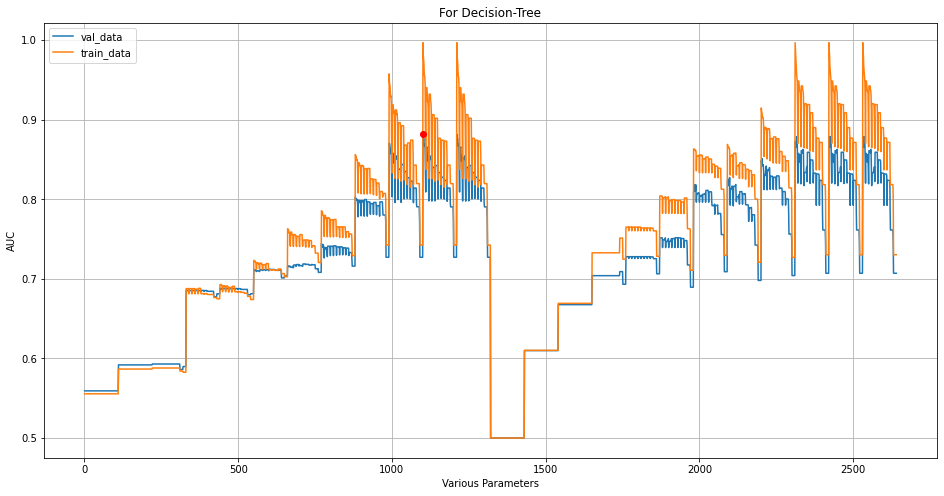

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(cnt, dt_accuracy_val, label='val_data')
plt.plot(cnt, dt_accuracy_train, label='train_data')
plt.plot(dt_best, dt_accu_best, marker='o', color='red')
plt.grid()
plt.xlabel("Various Parameters")
plt.ylabel("AUC")
plt.title("For Decision-Tree")
plt.legend(loc='upper left')
plt.show()

In [ ]:
mdt_classifier = DecisionTreeClassifier(criterion='gini',max_depth=50,min_samples_leaf=1,min_samples_split=2,random_state=42)
mdt_classifier.fit(mX_train,my_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=50, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [ ]:
mdt_predictions = mdt_classifier.predict(mX_test)
print(mdt_predictions.shape)
mdt_predictions

(1092, 5)


array([[0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0],
       ...,
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0]])

In [ ]:
# evaluation
mdt_auc = metrics.roc_auc_score(my_test, mdt_predictions)
print("accuracy = ",mdt_auc)

accuracy =  0.9034134256545585


##**Bi-Directional LSTM**

### **Model Preparation**

In [ ]:
from tensorflow.keras import regularizers

In [ ]:
def lstm_model(n_features, n_outputs):
    model = Sequential()
    model.add(Bidirectional(LSTM(1000, activation='relu', return_sequences=True), input_shape=(1, n_features)))
    model.add(Bidirectional(LSTM(500, activation='relu', return_sequences=True)))
    model.add(Bidirectional(LSTM(250, activation='relu', return_sequences=True)))
    model.add(Flatten())
    model.add(Dropout(0.1))
    model.add(Dense(128))
    model.add(Dense(n_outputs, activation="sigmoid"))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','AUC'])
    print(model.summary())
    return model

### **Input Preparation**

In [ ]:
n_inputs, n_outputs = mdf_X.shape[1], mdf_Y.shape[1]

In [ ]:
n_samples = len(mX_train)
n_features = n_inputs
train_X = mX_train.to_numpy().reshape(n_samples, 1, n_features)
train_y = my_train.to_numpy()

###**Model Fitting**

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Bidirectional, LSTM, Dropout, BatchNormalization, Flatten

In [ ]:
lstm_mod = lstm_model(n_inputs, n_outputs)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 1, 2000)           15056000  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 1, 1000)           10004000  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 1, 500)            2502000   
_________________________________________________________________
flatten (Flatten)            (None, 500)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               64128     
_________________________________________________________________
dense_6 (Dense)              (None, 5)                

In [ ]:
history = lstm_mod.fit(train_X, train_y, epochs=100, validation_split=0.2)

Epoch 1/100
110/110 [==============================] - 36s 263ms/step - loss: 0.3514 - accuracy: 0.5762 - auc: 0.6992 - val_loss: 0.1518 - val_accuracy: 0.6357 - val_auc: 0.9472
Epoch 2/100
110/110 [==============================] - 28s 251ms/step - loss: 0.1460 - accuracy: 0.6626 - auc: 0.9500 - val_loss: 0.1149 - val_accuracy: 0.6323 - val_auc: 0.9715
Epoch 3/100
110/110 [==============================] - 28s 252ms/step - loss: 0.1077 - accuracy: 0.6362 - auc: 0.9709 - val_loss: 0.0921 - val_accuracy: 0.5945 - val_auc: 0.9801
Epoch 4/100
110/110 [==============================] - 28s 251ms/step - loss: 0.1084 - accuracy: 0.6432 - auc: 0.9726 - val_loss: 0.0990 - val_accuracy: 0.7297 - val_auc: 0.9776
Epoch 5/100
110/110 [==============================] - 28s 250ms/step - loss: 0.0745 - accuracy: 0.6742 - auc: 0.9869 - val_loss: 0.0899 - val_accuracy: 0.6529 - val_auc: 0.9816
Epoch 6/100
110/110 [==============================] - 28s 250ms/step - loss: 0.0628 - accuracy: 0.6346 - auc:

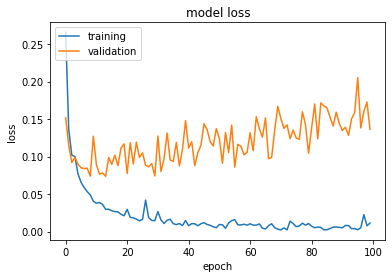

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

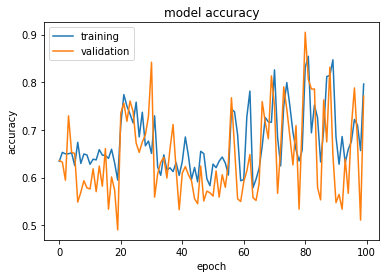

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

###**Prediction**

In [ ]:
n_samples_test = len(mX_test)
n_features = n_inputs
lstm_test_X = mX_test.to_numpy().reshape(n_samples_test, 1, n_features)

In [ ]:
lstm_predictions = lstm_mod.predict(lstm_test_X)

lstm_predictions[lstm_predictions > 0.5] = 1
lstm_predictions[lstm_predictions <= 0.5] = 0
lstm_predictions

array([[0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
# evaluation
lstm_auc = metrics.roc_auc_score(my_test, lstm_predictions)
print("AUC = ",lstm_auc)

AUC =  0.9180854098207586


##**Baseline Neural Network**

In [ ]:
n_inputs, n_outputs = mdf_X.shape[1], mdf_Y.shape[1]

###**PCA (Optional)**

In [ ]:
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import random as sparse_random

In [ ]:
def transform_data(X_arg, n):
    print("transform_data is called", n)
    svd = TruncatedSVD(n_components=int(n - 1), n_iter=7, random_state=42)
    tr_X = svd.fit(X_arg)
    X_vals = tr_X.transform(X_arg)
    
    X_vals = pd.DataFrame(X_vals)
    print(X_vals.shape)
    return X_vals, n - 1

In [ ]:
X_features, n_inputs_pca = transform_data(mdf_X, mdf_X.shape[1])

transform_data is called 881
(5457, 880)


In [ ]:
# Sparsity after transformation

a = (X_features.to_numpy() == 0).mean()
print("Sparsity of fingerprints data is {}".format(a))

Sparsity of fingerprints data is 0.01723349492728272


###**Model Fitting**

In [ ]:
def get_model_baseline(n_inputs, n_outputs ):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(20, input_dim=n_inputs,  kernel_initializer='he_uniform', activation='relu'))
    model.add(tf.keras.layers.Dense(200, activation='relu'))
    #model.add(tf.keras.layers.LSTM(300, activation='relu'))
    model.add(tf.keras.layers.Dense(100, activation='relu'))
    model.add(tf.keras.layers.Dense(n_outputs, activation='sigmoid'))
    model.compile( loss='BinaryCrossentropy', optimizer='adam', metrics=['accuracy', 'AUC'])
    return model

In [ ]:
import numpy as np
from keras.layers import Dropout

bs_x_train, bs_Y_train = np.array(mX_train), np.array(my_train)

#Reshape the data into 3-D array
#bs_x_train = np.reshape(bs_x_train, (bs_x_train.shape[0],bs_x_train.shape[1], 1))
#bs_x_train.shape

In [ ]:
import tensorflow as tf 

In [ ]:
bs_mod = get_model_baseline(n_inputs, n_outputs)

In [ ]:
history = bs_mod.fit(mX_train, my_train, epochs=200, validation_split=0.2)

Epoch 1/200
110/110 [==============================] - 2s 8ms/step - loss: 0.3495 - accuracy: 0.4704 - auc: 0.6852 - val_loss: 0.1655 - val_accuracy: 0.6529 - val_auc: 0.9253
Epoch 2/200
110/110 [==============================] - 0s 4ms/step - loss: 0.1631 - accuracy: 0.6491 - auc: 0.9314 - val_loss: 0.1280 - val_accuracy: 0.5155 - val_auc: 0.9601
Epoch 3/200
110/110 [==============================] - 0s 4ms/step - loss: 0.1212 - accuracy: 0.6117 - auc: 0.9631 - val_loss: 0.1001 - val_accuracy: 0.6392 - val_auc: 0.9740
Epoch 4/200
110/110 [==============================] - 0s 4ms/step - loss: 0.0952 - accuracy: 0.6464 - auc: 0.9797 - val_loss: 0.1002 - val_accuracy: 0.5716 - val_auc: 0.9766
Epoch 5/200
110/110 [==============================] - 0s 4ms/step - loss: 0.0865 - accuracy: 0.6251 - auc: 0.9837 - val_loss: 0.0876 - val_accuracy: 0.6392 - val_auc: 0.9780
Epoch 6/200
110/110 [==============================] - 0s 4ms/step - loss: 0.0780 - accuracy: 0.6612 - auc: 0.9862 - val_loss

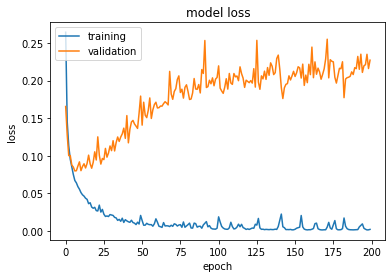

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

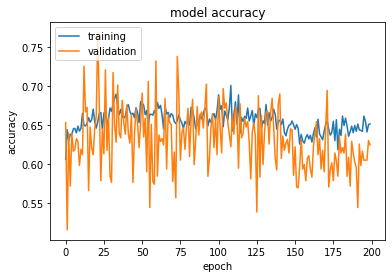

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

###**Prediction**

In [ ]:
#bs_x_test = np.array(X_test)

#Reshape the data into 3-D array
#bs_x_test = np.reshape(bs_x_test, (bs_x_test.shape[0],bs_x_test.shape[1],1))

In [ ]:
bs_predictions = bs_mod.predict(mX_test)

bs_predictions[bs_predictions > 0.5] = 1
bs_predictions[bs_predictions <= 0.5] = 0
bs_predictions

array([[0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
bs_auc = metrics.roc_auc_score(my_test,bs_predictions)
print("AUC = ",bs_auc)

AUC =  0.9258821084442055


##**Random Forests**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [ ]:
# Random Forest
# Hyper-tunning the 'criterion', 'n_estimators', 'max_depth', 'min_sample_leaf' and 'min_sample_split' parameter
criterion = ['gini', 'entropy']
n_estimators = [1,5,10,50,100]
max_depth = [1,2,3,4,5,6,7,8,10,20,50,]
min_samples_leaf = [1,2,3,4,5,6,7,8,10,20,50]
min_samples_split = [2,3,4,5,6,7,8,10,20,50]
rf_accuracy_val = []
rf_accuracy_train = []
parameter = []
rf_df = pd.DataFrame(columns=['Parameters', 'val_Accuracy', 'train_Accuracy'])
count = 0
cnt = []

for i in criterion:
    for j in max_depth:
        for k in min_sample_leaf:
            for l in min_sample_split:
                for m in n_estimators:
                  count+=1
                  rf_clf = RandomForestClassifier(criterion=i, max_depth=j, min_samples_leaf=k, min_samples_split=l, n_estimators=m, random_state=42)
                  rf_clf.fit(mX_val_train, my_val_train)
                  rf_pred = rf_clf.predict(mX_val)
                  rf_acc = metrics.roc_auc_score(my_val, rf_pred)
                  rf_accuracy_val.append(rf_acc)
                  
                  rf_pred = rf_clf.predict(mX_val_train)
                  rf_acc = metrics.roc_auc_score(my_val_train, rf_pred)
                  rf_accuracy_train.append(rf_acc)
                  cnt.append(count)
                  para = '[criterion = '+str(i)+', max_depth = '+str(j)+', min_sample_leaf = '+str(k)+', min_sample_split = '+str(l)+', n_estimators = '+str(m)+']'
                  parameter.append(para)

In [ ]:
rf_df['Parameters'] = parameter
rf_df['val_Accuracy'] = rf_accuracy_val
rf_df['train_Accuracy'] = rf_accuracy_train
rf_df['difference'] = abs(rf_df['val_Accuracy'] - rf_df['train_Accuracy'])
rf_df["count"] = cnt
rfdf = rf_df[rf_df.iloc[:,1]<rf_df.iloc[:,2]]

rf_best, rf_accu_best, best_para = rfdf.sort_values(['val_Accuracy','difference'], ascending=[False,True]).head(1)[['count', 'val_Accuracy', 'Parameters']].values[0]
print("Best Parameter for Random Forest =", best_para, rf_accu_best)

Best Parameter for Random Forest = [criterion = gini, max_depth = 50, min_sample_leaf = 1, min_sample_split = 3, n_estimators = 100] 0.8887265226873524


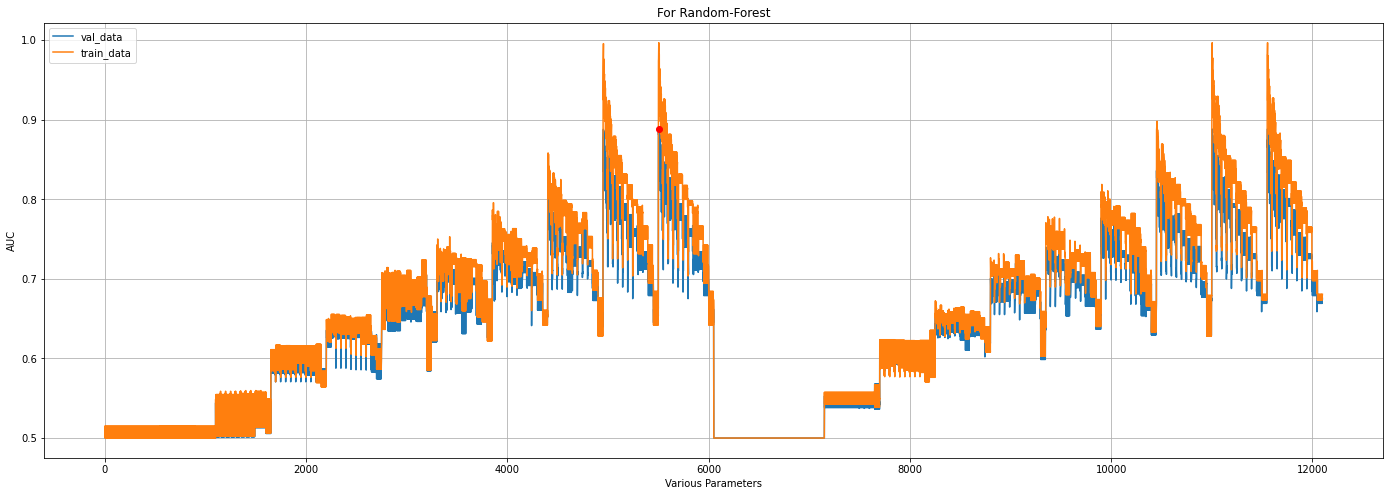

In [ ]:
plt.figure(figsize=(24, 8))
plt.plot(cnt, rf_accuracy_val, label='val_data')
plt.plot(cnt, rf_accuracy_train, label='train_data')
plt.plot(rf_best, rf_accu_best, marker='o', color='red')
plt.grid()
plt.xlabel("Various Parameters")
plt.ylabel("AUC")
plt.title("For Random-Forest")
plt.legend(loc='upper left')
plt.show()

In [ ]:
mrf_classifier = RandomForestClassifier(criterion='gini',n_estimators=100,max_depth=50,min_samples_leaf=1,min_samples_split=3,random_state=42)

In [ ]:
mrf_classifier.fit(mX_train,my_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=50, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
# predict
mrf_predictions = mrf_classifier.predict(mX_test)
print(mrf_predictions.shape)
mrf_predictions

(1092, 5)


array([[0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0],
       ...,
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0]])

In [ ]:
# evaluation
mrf_auc = metrics.roc_auc_score(my_test, mrf_predictions)
print("AUC = ",mrf_auc)

AUC =  0.8953477242212052


##**Model Comparison & Save .h5/.pkl file**

In [ ]:
multi_mods_acc = {'mdt_classifier': mdt_auc,'lstm_mod':lstm_auc,'bs_mod': bs_auc, 'mrf_classifier':mrf_auc}
multi_mods = {'mdt_classifier': mdt_classifier,'lstm_mod':lstm_mod,'bs_mod':bs_mod,'mrf_classifier':mrf_classifier}

In [ ]:
selected_multi_model = max(multi_mods_acc, key=multi_mods_acc.get)
selected_multi_model

'bs_mod'

In [ ]:
import h5py 
from sklearn.externals import joblib

In [ ]:
if '_mod' in selected_multi_model:
  file_name = selected_target+'_M_'+selected_multi_model+'.h5'
  selected_model = multi_mods.get(selected_multi_model)
  selected_model.save(file_name)
else :
  file_name = selected_target+'_M_'+selected_multi_model+'.pkl'
  joblib.dump(multi_mods.get(selected_multi_model), file_name)

#**Modeling - Binary**

In [ ]:
#selected_target = 'CHEMBL1955'
#binary_dataset_filename = 'CHEMBL1955_Binary_modeling_dataset.csv'

In [ ]:
import pandas as pd

df = pd.read_csv(binary_dataset_filename)
df.head(2)

,bioactivity_class,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,PubchemFP36,PubchemFP37,PubchemFP38,...,PubchemFP841,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_X = df.drop(columns='bioactivity_class')
print(df_X.shape)
df_X.head(2)

(226, 881)


,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,PubchemFP36,PubchemFP37,PubchemFP38,PubchemFP39,...,PubchemFP841,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_Y = df.bioactivity_class
df_Y.shape

(226,)

##**Split 80/20**

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
y_train, y_test, X_train, X_test = train_test_split(df_Y, df_X, test_size=0.2)

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((180, 881), (180,), (46, 881), (46,))

In [ ]:
X_train.to_csv('binary_X_train.csv', index=False)
X_test.to_csv('binary_X_test.csv', index=False)
y_train.to_csv('binary_y_train.csv', index=False)
y_test.to_csv('binary_y_test.csv', index=False)

In [ ]:
# Split validation set (20%)
y_val_train, y_val, X_val_train, X_val= train_test_split(y_train, X_train, test_size=0.2)

In [ ]:
X_val_train.to_csv('binary_X_val_train.csv', index=False)
X_val.to_csv('binary_X_val.csv', index=False)
y_val_train.to_csv('binary_y_val_train.csv', index=False)
y_val.to_csv('binary_y_val.csv', index=False)

## **Decision Tree**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

Best Parameter for Decision Tree = [criterion = entropy, max_depth = 7, min_sample_leaf = 2, min_sample_split = 2]


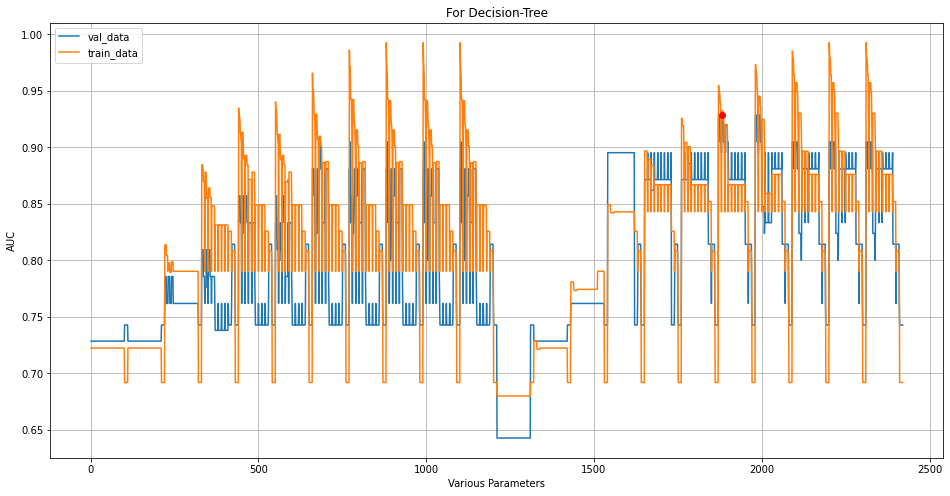

In [ ]:
# Decision Tree
# Hyper-tunning the 'criterion', 'max_depth', 'min_sample_leaf' and 'min_sample_split' parameter
import matplotlib.pyplot as plt

criterion = ['gini', 'entropy']
max_depth = [1,2,3,4,5,6,7,8,10,20,50,]
min_sample_leaf = [1,2,3,4,5,6,7,8,10,20,50]
min_sample_split = [2,3,4,5,6,7,8,10,20,50]
dt_accuracy_val = []
dt_accuracy_train = []
parameter = []
dt_df = pd.DataFrame(columns=['Parameters', 'val_Accuracy', 'train_Accuracy'])
count = 0
cnt = []

for i in criterion:
    for j in max_depth:
        for k in min_sample_leaf:
            for l in min_sample_split:
                count+=1
                dt_clf = DecisionTreeClassifier(criterion=i, max_depth=j, min_samples_leaf=k, min_samples_split=l, random_state=42)
                dt_clf.fit(X_val_train, y_val_train)
                dt_pred = dt_clf.predict(X_val)
                dt_acc = metrics.roc_auc_score(y_val, dt_pred)
                dt_accuracy_val.append(dt_acc)
                
                dt_pred = dt_clf.predict(X_val_train)
                dt_acc = metrics.roc_auc_score(y_val_train, dt_pred)
                dt_accuracy_train.append(dt_acc)
                cnt.append(count)
                para = '[criterion = '+str(i)+', max_depth = '+str(j)+', min_sample_leaf = '+str(k)+', min_sample_split = '+str(l)+']'
                parameter.append(para)

In [ ]:
dt_df['Parameters'] = parameter
dt_df['val_Accuracy'] = dt_accuracy_val
dt_df['train_Accuracy'] = dt_accuracy_train
dt_df['difference'] = abs(dt_df['val_Accuracy'] - dt_df['train_Accuracy'])
dt_df["count"] = cnt
dtdf = dt_df[dt_df.iloc[:,1]<dt_df.iloc[:,2]]

dt_best, dt_accu_best, best_para = dtdf.sort_values(['val_Accuracy','difference'], ascending=[False,True]).head(1)[['count', 'val_Accuracy', 'Parameters']].values[0]
print("Best Parameter for Decision Tree =", best_para)

ValueError: ignored

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(cnt, dt_accuracy_val, label='val_data')
plt.plot(cnt, dt_accuracy_train, label='train_data')
plt.plot(dt_best, dt_accu_best, marker='o', color='red')
plt.grid()
plt.xlabel("Various Parameters")
plt.ylabel("AUC")
plt.title("For Decision-Tree")
plt.legend(loc='upper left')
plt.show()

In [ ]:
dt_classifier = DecisionTreeClassifier(criterion='gini', max_depth=7, min_samples_leaf=2, min_samples_split=2, random_state=42)
dt_classifier.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=7, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [ ]:
#predict
dt_predictions = dt_classifier.predict(X_test)

In [ ]:
# evaluation
dt_auc = metrics.roc_auc_score(y_test, dt_predictions)
print("AUC = ",dt_auc)

AUC =  0.8171428571428572


## **Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [ ]:
# Random Forest
# Hyper-tunning the 'criterion', 'n_estimators', 'max_depth', 'min_sample_leaf' and 'min_sample_split' parameter
criterion = ['gini', 'entropy']
n_estimators = [1,5,10,50,100]
max_depth = [1,2,3,4,5,6,7,8,10,20,50,]
min_samples_leaf = [1,2,3,4,5,6,7,8,10,20,50]
min_samples_split = [2,3,4,5,6,7,8,10,20,50]
rf_accuracy_val = []
rf_accuracy_train = []
parameter = []
rf_df = pd.DataFrame(columns=['Parameters', 'val_Accuracy', 'train_Accuracy'])
count = 0
cnt = []

for i in criterion:
    for j in max_depth:
        for k in min_sample_leaf:
            for l in min_sample_split:
                for m in n_estimators:
                  count+=1
                  rf_clf = RandomForestClassifier(criterion=i, max_depth=j, min_samples_leaf=k, min_samples_split=l, n_estimators=m, random_state=42)
                  rf_clf.fit(X_val_train, y_val_train)
                  rf_pred = rf_clf.predict(X_val)
                  rf_acc = metrics.roc_auc_score(y_val, rf_pred)
                  rf_accuracy_val.append(rf_acc)
                  
                  rf_pred = rf_clf.predict(X_val_train)
                  rf_acc = metrics.roc_auc_score(y_val_train, rf_pred)
                  rf_accuracy_train.append(rf_acc)
                  cnt.append(count)
                  para = '[criterion = '+str(i)+', max_depth = '+str(j)+', min_sample_leaf = '+str(k)+', min_sample_split = '+str(l)+', n_estimators = '+str(m)+']'
                  parameter.append(para)

In [ ]:
rf_df['Parameters'] = parameter
rf_df['val_Accuracy'] = rf_accuracy_val
rf_df['train_Accuracy'] = rf_accuracy_train
rf_df['difference'] = abs(rf_df['val_Accuracy'] - rf_df['train_Accuracy'])
rf_df["count"] = cnt
rfdf = rf_df[rf_df.iloc[:,1]<rf_df.iloc[:,2]]

rf_best, rf_accu_best, best_para = rfdf.sort_values(['val_Accuracy','difference'], ascending=[False,True]).head(1)[['count', 'val_Accuracy', 'Parameters']].values[0]
print("Best Parameter for Random Forest =", best_para, rf_accu_best)

Best Parameter for Random Forest = [criterion = entropy, max_depth = 10, min_sample_leaf = 1, min_sample_split = 2, n_estimators = 10] 0.9666666666666667


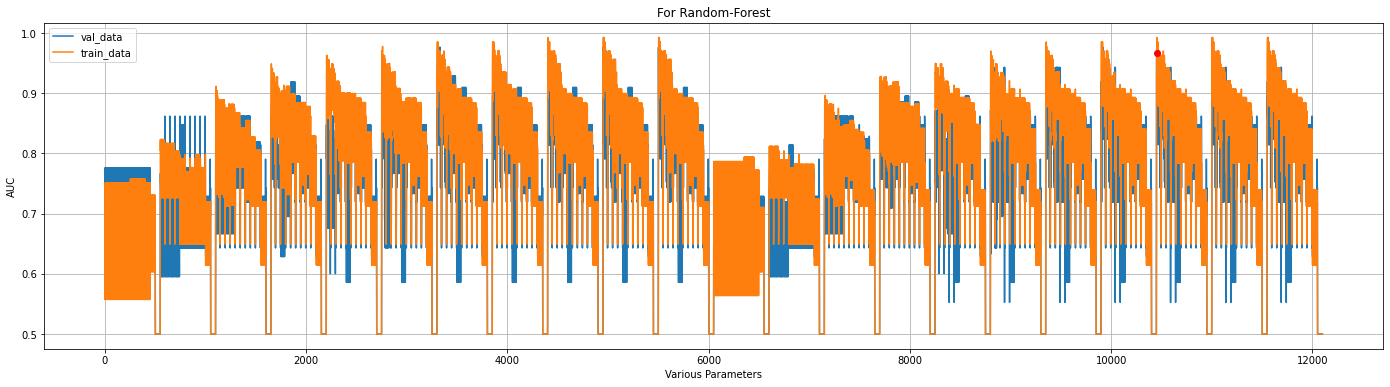

In [ ]:
plt.figure(figsize=(24, 6))
plt.plot(cnt, rf_accuracy_val, label='val_data')
plt.plot(cnt, rf_accuracy_train, label='train_data')
plt.plot(rf_best, rf_accu_best, marker='o', color='red')
plt.grid()
plt.xlabel("Various Parameters")
plt.ylabel("AUC")
plt.title("For Random-Forest")
plt.legend(loc='upper left')
plt.show()

In [ ]:
rf_classifier = RandomForestClassifier(criterion='entropy',max_depth=10,min_samples_leaf=1,min_samples_split=2,n_estimators=10,random_state=42)

In [ ]:
rf_classifier.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
# predict
rf_predictions = rf_classifier.predict(X_test)

In [ ]:
# evaluation
rf_auc = metrics.roc_auc_score(y_test, rf_predictions)
print("AUC = ",rf_auc)

AUC =  0.8047619047619048


##**Support Vector Machine**

In [ ]:
from sklearn.svm import SVC

In [ ]:
# Hyper-tunning the 'kernel' and 'gamma' parameter
svc_dict = {'auto': ['linear'], 'scale': ['linear', 'poly', 'rbf', 'sigmoid']}
svc_accuracy_val = []
svc_accuracy_train = []
svc_df = pd.DataFrame(columns=['Parameters', 'val_Accuracy', 'train_Accuracy'])
parameter = []
cnt = []
count = 0
for i in svc_dict:
    for j in svc_dict[i]:
        count+=1
        svc_clf = SVC(kernel=j, gamma=i, random_state=42)
        svc_clf.fit(X_val_train, y_val_train)
        svc_pred = svc_clf.predict(X_val)
        svc_acc = metrics.roc_auc_score(y_val,svc_pred)
        svc_accuracy_val.append(svc_acc)

        svc_pred = svc_clf.predict(X_val_train)
        svc_acc = metrics.roc_auc_score(y_val_train, svc_pred)
        svc_accuracy_train.append(svc_acc)
        cnt.append(count)
        para = '[gamma = '+str(i)+', kernel = '+str(j)+']'
        parameter.append(para)

In [ ]:
svc_df['Parameters'] = parameter
svc_df['val_Accuracy'] = svc_accuracy_val
svc_df['train_Accuracy'] = svc_accuracy_train
svc_df['difference'] = abs(svc_df['val_Accuracy'] - svc_df['train_Accuracy'])
svc_df["count"] = cnt
svcdf = svc_df[svc_df.iloc[:,1]<svc_df.iloc[:,2]]

svc_best, svc_accu_best, best_para = svcdf.sort_values(['val_Accuracy','difference'], ascending=[False,True]).head(1)[['count', 'val_Accuracy', 'Parameters']].values[0]
print('Best Parameter for Support Vector Machine(SVC) = ', best_para, svc_accu_best)

Best Parameter for Support Vector Machine(SVC) =  [gamma = auto, kernel = linear] 0.8714285714285714


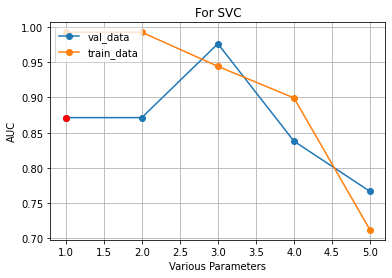

In [ ]:
plt.plot(cnt, svc_accuracy_val, label='val_data', marker ='o')
plt.plot(cnt, svc_accuracy_train, label='train_data', marker='o')
plt.plot(svc_best, svc_accu_best, marker='o', color='red')
plt.grid()
plt.xlabel("Various Parameters")
plt.ylabel("AUC")
plt.title("For SVC")
plt.legend(loc='upper left')
plt.show()

In [ ]:
svm_classifier = SVC(kernel='linear',gamma='auto',random_state=42)
svm_classifier.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [ ]:
#predict
svm_predictions = svm_classifier.predict(X_test)

In [ ]:
svm_auc = metrics.roc_auc_score(y_test, svm_predictions)
print("AUC = ",svm_auc)

AUC =  0.7685714285714287


##**Logistic Regression**

In [ ]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

In [ ]:
# Hyper-tunning the 'penalty' and 'solver' parameter
lr_dict = {'l1': ['liblinear', 'saga'], 'l2': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
lr_accuracy_val = []
lr_accuracy_train = []
lr_accuracy_cv = []
lr_df = pd.DataFrame(columns=['Parameters', 'val_Accuracy', 'train_Accuracy'])
parameter = []
cnt = []
count = 0

for i in lr_dict:
    for j in lr_dict[i]:
        count+=1
        lr_clf = LogisticRegression(penalty=i, solver=j, random_state=42)
        lr_clf.fit(X_val_train, y_val_train)
        lr_pred = lr_clf.predict(X_val)
        lr_acc = metrics.roc_auc_score(y_val, lr_pred)
        lr_accuracy_val.append(lr_acc)

        lr_pred = lr_clf.predict(X_val_train)
        lr_acc = metrics.roc_auc_score(y_val_train, lr_pred)
        lr_accuracy_train.append(lr_acc)
        cnt.append(count)
        para = '[penalty = '+str(i)+', solver = '+str(j)+']'
        parameter.append(para)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_m

In [ ]:
lr_df['Parameters'] = parameter
lr_df['val_Accuracy'] = lr_accuracy_val
lr_df['train_Accuracy'] = lr_accuracy_train
lr_df['difference'] = abs(lr_df['val_Accuracy'] - lr_df['train_Accuracy'])
lr_df["count"] = cnt
lrdf = lr_df[lr_df.iloc[:,1]<lr_df.iloc[:,2]]
lr_best, lr_accu_best, best_para = lrdf.sort_values(['val_Accuracy','difference'], ascending=[False,True]).head(1)[['count', 'val_Accuracy', 'Parameters']].values[0]
print('Best Parameters for Logistic Regression =', best_para)

Best Parameters for Logistic Regression = [penalty = l2, solver = newton-cg]


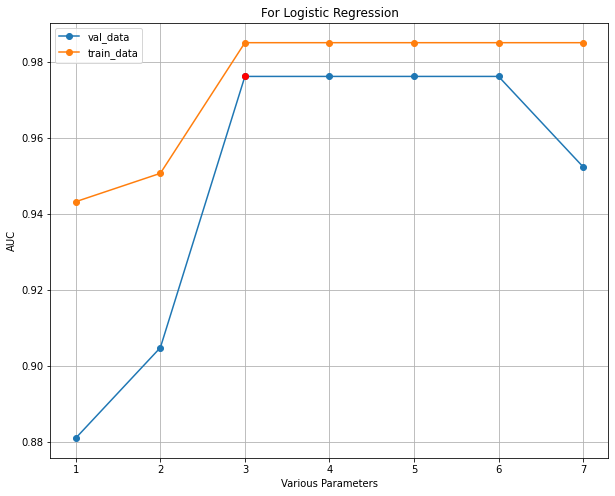

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(cnt, lr_accuracy_val, label='val_data', marker ='o')
plt.plot(cnt, lr_accuracy_train, label='train_data', marker='o')
plt.plot(lr_best, lr_accu_best, marker='o', color='red')
plt.grid()
plt.xlabel("Various Parameters")
plt.ylabel("AUC")
plt.title("For Logistic Regression")
plt.legend(loc='upper left')
plt.show()

In [ ]:
lr_classifier = LogisticRegression(penalty='l2', solver='newton-cg', random_state=42)
lr_classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
#predict
lr_predictions = lr_classifier.predict(X_test)

In [ ]:
lr_auc = metrics.roc_auc_score(y_test, lr_predictions)
print("AUC = ",lr_auc)

AUC =  0.9


##**Deep Neural Network**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.4.1


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=150, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)

In [ ]:
dnn_mod = keras.Sequential()
# Deep Neural Network(DNN)
dnn_mod = keras.Sequential([
              layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001), input_shape=[len(X_train.keys())]),
              layers.Dense(16, activation='relu'),
              layers.Dropout(0.5),
              layers.Dense(16, activation='relu'),
              layers.Dense(8, activation='relu'),
              layers.Dense(1, activation='sigmoid')
              ])

In [ ]:
dnn_mod.compile(optimizer='adam',
        loss=tf.keras.losses.binary_crossentropy,
        metrics=['accuracy'])

In [ ]:
history = dnn_mod.fit(X_train, y_train, epochs=50, validation_split=0.2, callbacks=callback)

Epoch 1/50
5/5 [==============================] - 1s 129ms/step - loss: 0.9060 - accuracy: 0.5038 - val_loss: 0.8045 - val_accuracy: 0.4444
Epoch 2/50
5/5 [==============================] - 0s 12ms/step - loss: 0.7783 - accuracy: 0.5398 - val_loss: 0.7802 - val_accuracy: 0.4444
Epoch 3/50
5/5 [==============================] - 0s 12ms/step - loss: 0.7359 - accuracy: 0.5612 - val_loss: 0.7728 - val_accuracy: 0.4444
Epoch 4/50
5/5 [==============================] - 0s 12ms/step - loss: 0.7076 - accuracy: 0.5749 - val_loss: 0.7481 - val_accuracy: 0.4722
Epoch 5/50
5/5 [==============================] - 0s 12ms/step - loss: 0.7045 - accuracy: 0.6309 - val_loss: 0.7234 - val_accuracy: 0.6389
Epoch 6/50
5/5 [==============================] - 0s 12ms/step - loss: 0.6513 - accuracy: 0.7274 - val_loss: 0.7101 - val_accuracy: 0.6389
Epoch 7/50
5/5 [==============================] - 0s 13ms/step - loss: 0.6042 - accuracy: 0.8325 - val_loss: 0.7016 - val_accuracy: 0.6944
Epoch 8/50
5/5 [==========

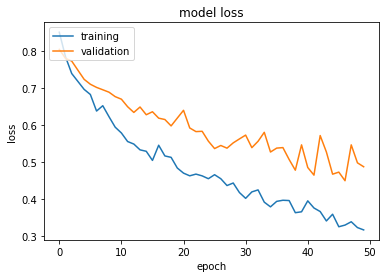

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

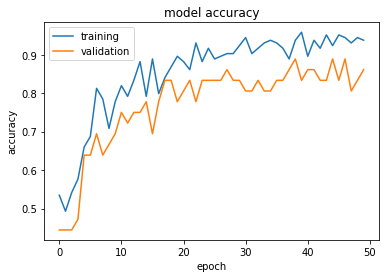

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

In [ ]:
#predict
dnn_predictions = dnn_mod.predict_classes(X_test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
#evaluation
dnn_auc = metrics.roc_auc_score(y_test, dnn_predictions)
print("AUC = ",dnn_auc)

AUC =  0.7647619047619048


##**Gradient Boosting**

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
# Gradient Boosting
gb_classifier = GradientBoostingClassifier(random_state=42)
gb_classifier.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [ ]:
#predict
gb_predictions = gb_classifier.predict(X_test)

In [ ]:
#evaluation
gb_auc = metrics.roc_auc_score(y_test, gb_predictions)
print("AUC = ",gb_auc)

AUC =  0.8723809523809524


##**Model Comparison & Save .h5/.pkl file**

In [ ]:
binary_mods_acc = {'dt_classifier': dt_auc,'rf_classifier':rf_auc,'svm_classifier': svm_auc, 'lr_classifier':lr_auc, 'dnn_mod':dnn_auc, 'gb_classifier':gb_auc}
binary_mods = {'dt_classifier': dt_classifier,'rf_classifier':rf_classifier,'svm_classifier': svm_classifier, 'lr_classifier':lr_classifier, 'dnn_mod':dnn_mod, 'gb_classifier':gb_classifier}

In [ ]:
selected_binary_model = max(binary_mods_acc, key=binary_mods_acc.get)
print(selected_binary_model,' AUC =',binary_mods_acc[selected_binary_model])

lr_classifier  AUC = 0.9


In [ ]:
import h5py 
from sklearn.externals import joblib

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
if '_classifier' in selected_binary_model:
  file_name = selected_target+'_B_'+selected_binary_model+'.pkl'
  joblib.dump(binary_mods.get(selected_binary_model), file_name)
else :
  file_name = selected_target+'_B_'+selected_binary_model+'.h5'
  selected_model = binary_mods.get(selected_binary_model)
  selected_model.save(file_name)